# Customer Churn Prediction Project

---
**Team Members:**
- Aditya Kotkar (PRN: 202301040009)
- Krishna Tolani (PRN: 202301040073)
- Rishi Waghmare (PRN: 202301040014)

**Institution:** MIT Academy of Engineering, Alandi, Pune  
**Academic Year:** 2025-2026

## 🎯 Project Aim

The goal of this project is to build and evaluate a series of machine learning models to predict **customer churn** for a telecom company.

We will analyze customer attributes, engineer a new "customer segment" feature using K-Means clustering, and then build and compare base classifiers against advanced ensemble models to find the most accurate predictor of churn.

## Step 1: Setup and Data Loading

First, we'll set up our environment by importing the necessary libraries for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and machine learning (`sklearn`).

We will then load our `WA_Fn-UseC_-Telco-Customer-Churn.csv` dataset.

In [1]:
# Import foundational libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB

In [2]:
# Set plot style
sns.set_style('whitegrid')

In [3]:
# Load the new dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [4]:
# Display the first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2: Exploratory Data Analysis (EDA)

Before building any models, we need to understand our data. This step involves checking for missing values, understanding the distribution of each feature, and analyzing the balance of our target variable (`Churn`).

In [5]:
# Get a summary of the dataset (Dtypes, non-null counts)
print("--- Dataset Info ---")
df.info()

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

In [6]:
# Get a statistical summary of the numerical features
print("--- Descriptive Statistics ---")
display(df.describe())

--- Descriptive Statistics ---


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
# Check the distribution of the target variable
print("--- Target Variable Distribution ---")
print(df['Churn'].value_counts())

--- Target Variable Distribution ---
Churn
No     5174
Yes    1869
Name: count, dtype: int64


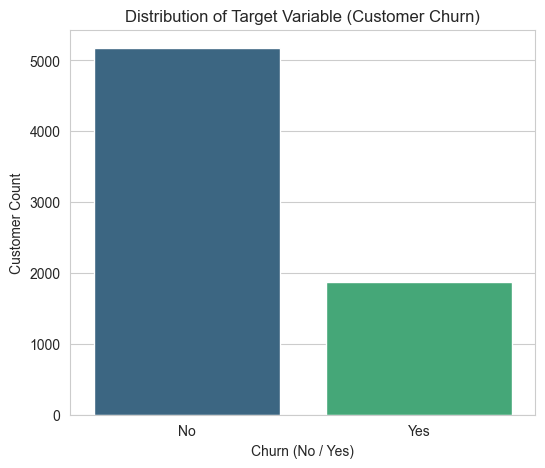

In [8]:
# Visualize the target variable distribution
plt.figure(figsize=(6, 5))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)
plt.title('Distribution of Target Variable (Customer Churn)')
plt.xlabel('Churn (No / Yes)')
plt.ylabel('Customer Count')
plt.show()

### 2.1 Data Cleaning and Feature Correlation

The EDA revealed several key preprocessing steps are needed:
1.  The `TotalCharges` column is an `object` type and must be converted to a number. This will also reveal some missing values that need to be dropped.
2.  The `customerID` column is not a feature and will be dropped.
3.  The `Churn` column (our target) needs to be converted from 'Yes'/'No' to `1`/`0`.
4.  All remaining categorical `object` columns (like `gender`, `Contract`, etc.) must be one-hot encoded.

After cleaning, we'll create a correlation heatmap to visualize how each feature relates to `Churn`.

In [9]:
# 1. Data Cleaning
# Convert 'TotalCharges' to numeric, errors='coerce' will turn blanks into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop the rows with NaN values (which are the ones from TotalCharges)
df_clean = df.dropna()

# Drop customerID as it's just an identifier
df_clean = df_clean.drop('customerID', axis=1)

In [10]:
# 2. Convert Target Variable
# Convert 'Churn' from 'Yes'/'No' to 1/0
df_clean['Churn'] = df_clean['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
# 3. One-hot encode all remaining categorical columns
# Identify object columns to encode (excluding 'Churn' which is already done)
categorical_cols = df_clean.select_dtypes(include=['object']).columns
df_processed = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# Display the .info() of the processed dataframe to see the new columns
print("--- Processed DataFrame Info ---")
df_processed.info()

--- Processed DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   Churn                                  7032 non-null   int64  
 5   gender_Male                            7032 non-null   bool   
 6   Partner_Yes                            7032 non-null   bool   
 7   Dependents_Yes                         7032 non-null   bool   
 8   PhoneService_Yes                       7032 non-null   bool   
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 

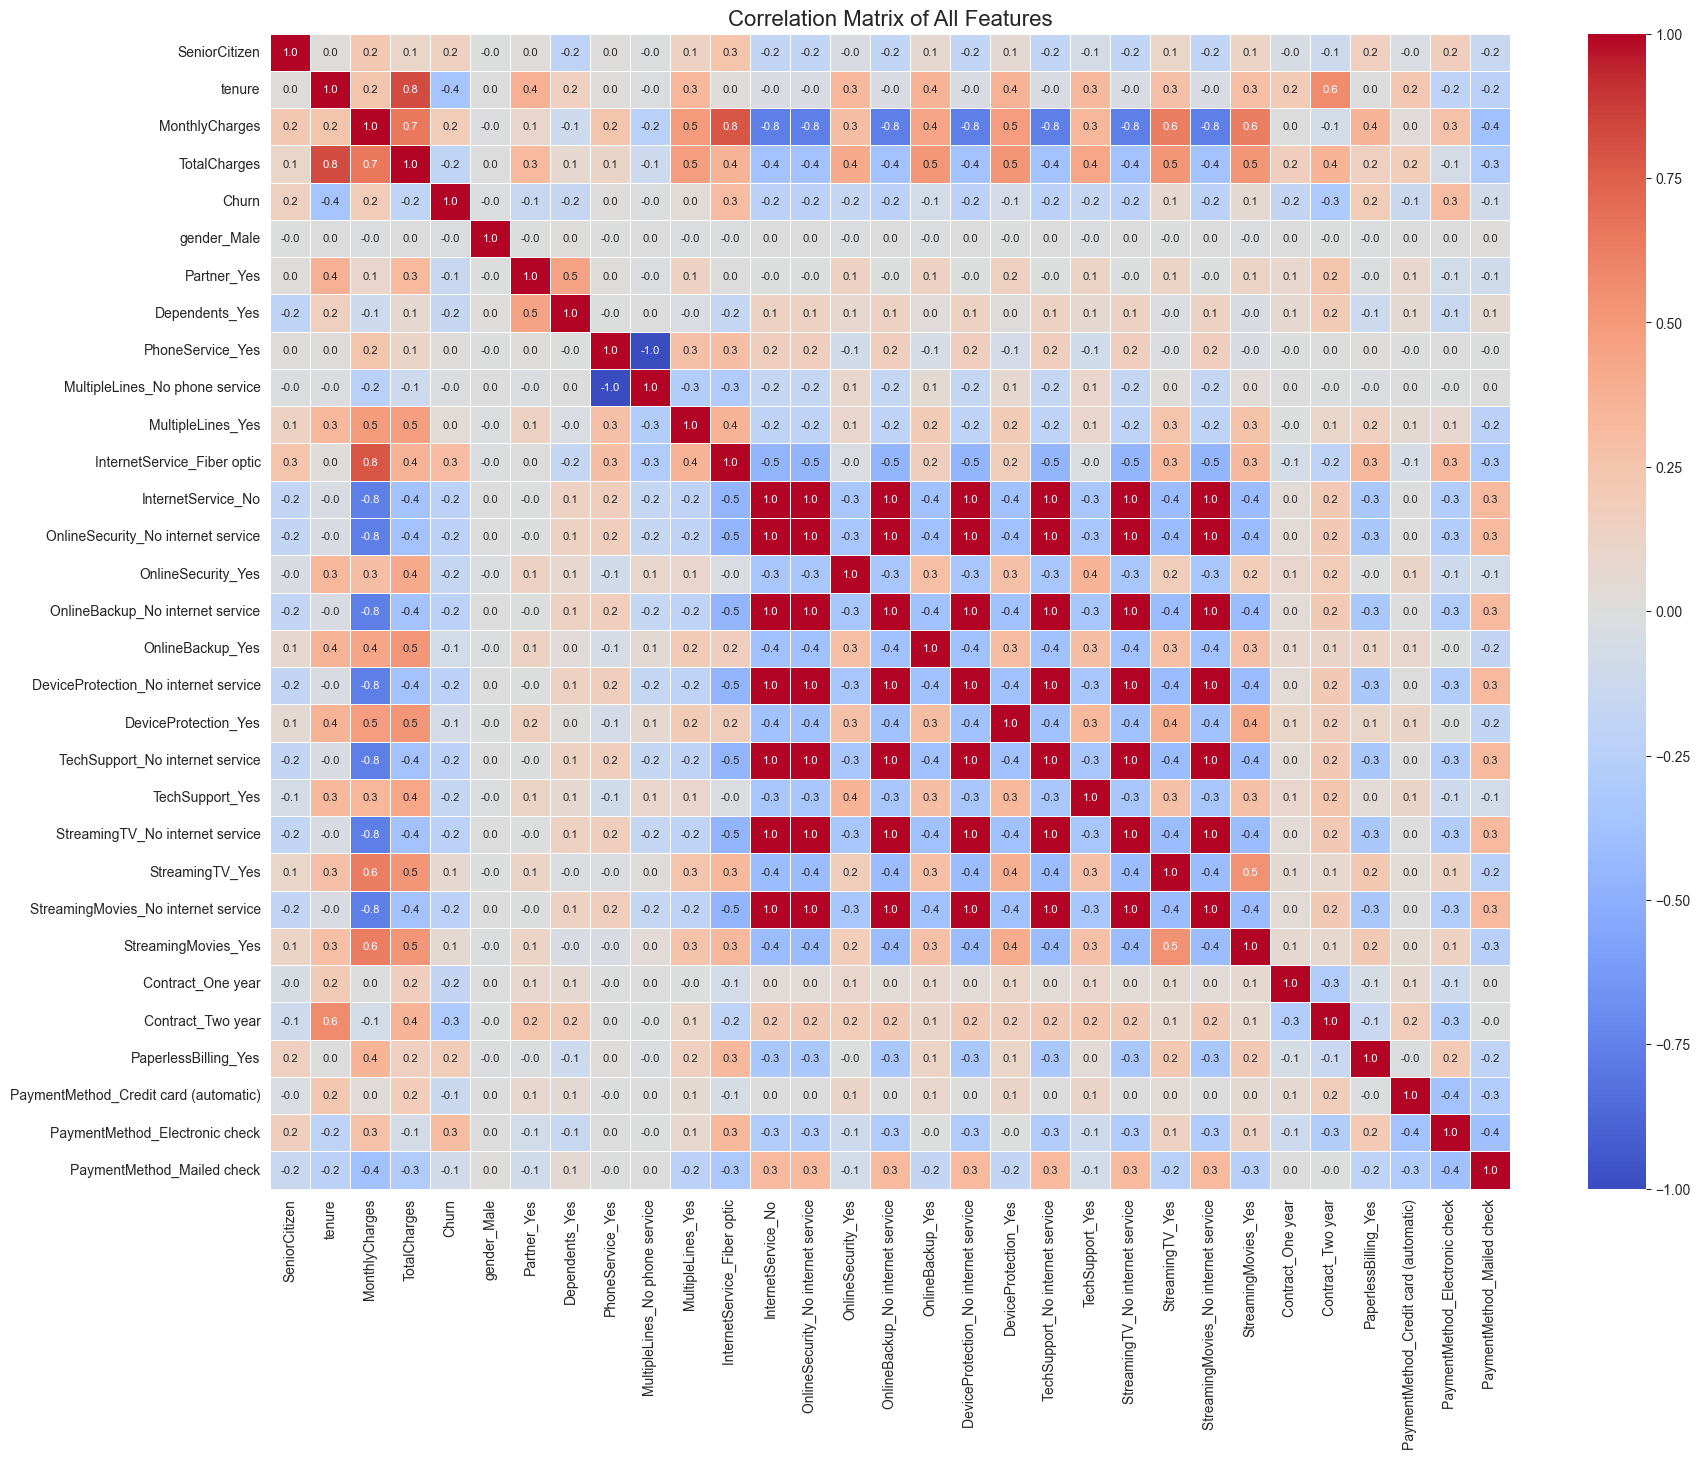

In [12]:
# 4. Correlation Heatmap
plt.figure(figsize=(20, 15))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of All Features', fontsize=16)
plt.show()

## Step 3: Feature Engineering with K-Means Clustering

Before we build our classification models, we can use clustering to create a new, powerful feature.

We will use **K-Means Clustering** on the primary financial attributes (`tenure`, `MonthlyCharges`, `TotalCharges`) to group customers into distinct segments. This new "Customer_Segment" feature will be added to our dataset and may help our classification models detect more nuanced patterns.

We'll use the **Elbow Method** to find the optimal number of clusters (`k`).

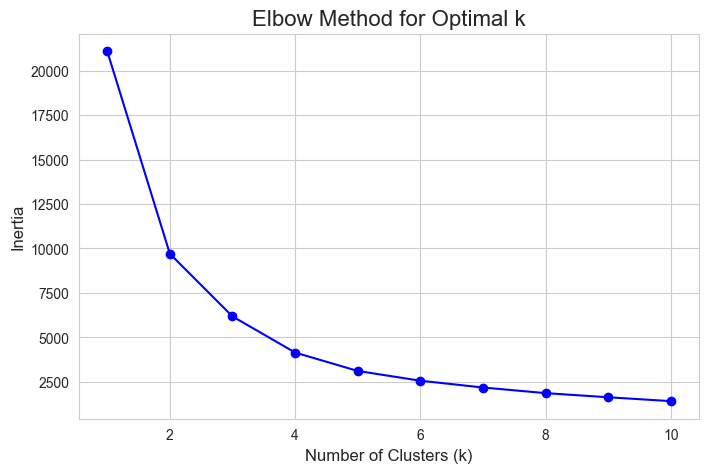

In [13]:
# Select the features for clustering
X_cluster = df_processed[['tenure', 'MonthlyCharges', 'TotalCharges']]

# Standardize these features (K-Means is distance-based)
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# --- Use the Elbow Method to find the optimal k ---
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.grid(True)
plt.show()

In [14]:
# --- Apply K-Means with the chosen k ---
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# Add the new cluster feature to our main processed dataframe
df_final = df_processed.copy()
df_final['Customer_Segment'] = cluster_labels

print(f"Successfully added 'Customer_Segment' feature with {optimal_k} clusters.")
df_final.head()

Successfully added 'Customer_Segment' feature with 5 clusters.


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Customer_Segment
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,True,False,True,False,1
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,0
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,True,False,False,True,1
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,3
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,2


## Step 4: Data Splitting and Scaling

Our data is now fully processed and feature-engineered. Before we can train our models, we must:
1.  Define our final feature matrix (`X`) and target vector (`y`).
2.  Split the data into training and testing sets. We will use `stratify=y` to ensure our training and test sets have the same proportion of churned customers as the original dataset.
3.  Apply `StandardScaler` to our features to ensure all values are on a consistent scale, which improves the performance of many algorithms.

In [15]:
# 1. Define X and y
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

In [16]:
# 2. Split the data (80% train, 20% test)
# We use stratify=y because our dataset is imbalanced (more 'No' than 'Yes')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split and scaled successfully.")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data split and scaled successfully.
X_train shape: (5625, 31)
X_test shape: (1407, 31)
y_train shape: (5625,)
y_test shape: (1407,)


## Step 5: Train and Evaluate Base Classification Models

With our data split and scaled, we can now train our base models. We will build, train, and evaluate the following four classifiers:
1.  **K-Nearest Neighbors (KNN):** A simple algorithm that classifies data based on its "neighbors."
2.  **Support Vector Machine (SVM):** A powerful model that finds the optimal hyperplane to separate classes.
3.  **Decision Tree:** A tree-based model that makes decisions by splitting on features.
4.  **Logistic Regression:** A linear model used for classification, which will serve as our baseline.
5.  **Naive Bayes:** A probabilistic classifier based on Bayes’ theorem, known for its simplicity and effectiveness on high-dimensional data.


We will train each on the `X_train_scaled` data and evaluate its performance on the `X_test_scaled` data.

In [18]:
# Create a dictionary to store our models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000), # Added max_iter for convergence
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42), # probability=True is needed for stacking
    "Naive Bayes": GaussianNB()

}

# Create a dictionary to store the results
results = {}

print("--- Evaluating Base Models ---")

# Loop through each model, train it, and store the results
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {'Accuracy': acc, 'F1-Score': f1}

    print(f"\nModel: {name}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Store the fitted models for later use in ensembles
base_models = list(models.items())

--- Evaluating Base Models ---

Model: Logistic Regression
  Accuracy: 0.8010
  F1-Score: 0.6000

Model: K-Nearest Neighbors
  Accuracy: 0.7505
  F1-Score: 0.5363

Model: Decision Tree
  Accuracy: 0.7058
  F1-Score: 0.4553

Model: Support Vector Machine
  Accuracy: 0.7882
  F1-Score: 0.5618

Model: Naive Bayes
  Accuracy: 0.6489
  F1-Score: 0.5636


## Step 6: Train and Evaluate Ensemble Models

We have our baseline performance from the individual models. The low F1-scores suggest our models struggle with the imbalanced data. We will now implement three advanced ensemble techniques to see if we can improve our F1-score and create a more robust predictor.

1.  **Voting Ensemble:** Combines the predictions from our base models (LR, KNN, and SVM) and predicts the class that gets the "majority vote."
2.  **AdaBoost Ensemble:** A boosting algorithm that learns from its mistakes by focusing on difficult-to-classify samples.
3.  **Stacking Ensemble:** A powerful technique that uses the predictions from our base models as new features to train a final "meta-classifier."

In [19]:
# --- 1. Voting Ensemble ---
# We use the 'probability'-enabled SVM and our other top models
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('knn', models['K-Nearest Neighbors']),
        ('svm', models['Support Vector Machine']),
        ('nb', models['Naive Bayes'])
    ],
    voting='soft' # 'soft' voting uses prediction probabilities and often performs better
)
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
acc_voting = accuracy_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
results['Voting Ensemble'] = {'Accuracy': acc_voting, 'F1-Score': f1_voting}

print("--- Voting Ensemble ---")
print(f"  Accuracy: {acc_voting:.4f}")
print(f"  F1-Score: {f1_voting:.4f}")

--- Voting Ensemble ---
  Accuracy: 0.7619
  F1-Score: 0.6017


In [20]:
# --- 2. AdaBoost Ensemble ---
# We use a Decision Tree as the base estimator, as is common with AdaBoost
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    random_state=42
)
ada_clf.fit(X_train_scaled, y_train)
y_pred_ada = ada_clf.predict(X_test_scaled)
acc_ada = accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
results['AdaBoost Ensemble'] = {'Accuracy': acc_ada, 'F1-Score': f1_ada}

print("--- AdaBoost Ensemble ---")
print(f"  Accuracy: {acc_ada:.4f}")
print(f"  F1-Score: {f1_ada:.4f}")

--- AdaBoost Ensemble ---
  Accuracy: 0.7939
  F1-Score: 0.5646


In [21]:
# --- 3. Stacking Ensemble ---
# Define the base models (estimators)
estimators = [
    ('lr', models['Logistic Regression']),
    ('knn', models['K-Nearest Neighbors']),
    ('svm', models['Support Vector Machine']),
    ('dt', models['Decision Tree']),
    ('nb', models['Naive Bayes'])

]
# Define the meta-classifier (we'll use Logistic Regression)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)
acc_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
results['Stacking Ensemble'] = {'Accuracy': acc_stacking, 'F1-Score': f1_stacking}

print("--- Stacking Ensemble ---")
print(f"  Accuracy: {acc_stacking:.4f}")
print(f"  F1-Score: {f1_stacking:.4f}")

--- Stacking Ensemble ---
  Accuracy: 0.8045
  F1-Score: 0.6110


## Step 7: Final Model Comparison and Conclusion

We have now trained and evaluated a total of seven models: four base classifiers and three ensemble models. It's time to compare their performance side-by-side to draw our final conclusions.

We will create a summary DataFrame for all model metrics and visualize their F1-scores to identify the top-performing model.

In [22]:
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("--- Final Model Performance Comparison ---")
display(results_df.style.highlight_max(subset=['Accuracy', 'F1-Score'], props='background-color: lightgreen; color: black;', ))

--- Final Model Performance Comparison ---


,Accuracy,F1-Score
Stacking Ensemble,0.804549,0.611033
Voting Ensemble,0.761905,0.601665
Logistic Regression,0.800995,0.600000
AdaBoost Ensemble,0.793888,0.564565
Naive Bayes,0.648898,0.563604
Support Vector Machine,0.788202,0.561765
K-Nearest Neighbors,0.750533,0.536328
Decision Tree,0.705757,0.455263


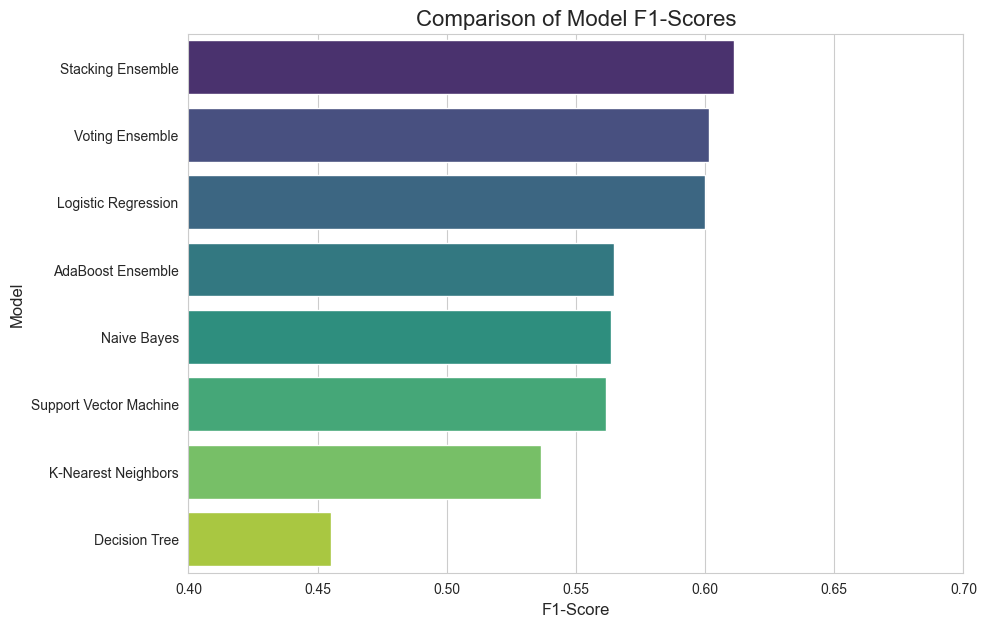

In [23]:
# --- Visualize Model Comparison ---
plt.figure(figsize=(10, 7))
sns.barplot(x=results_df['F1-Score'], y=results_df.index, palette='viridis', hue=results_df.index, legend=False)
plt.title('Comparison of Model F1-Scores', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0.4, 0.7)
plt.show()

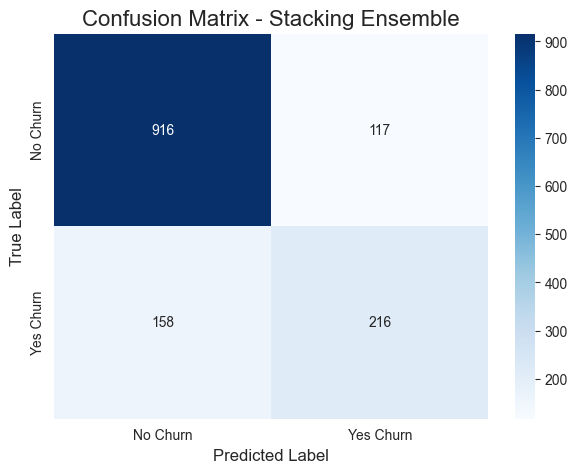

In [24]:
# --- Confusion Matrix for the Best Ensemble Model ---
best_model = stacking_clf
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Yes Churn'],
            yticklabels=['No Churn', 'Yes Churn'])
plt.title('Confusion Matrix - Stacking Ensemble', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

## 🏆 Final Conclusion

This project successfully developed and evaluated a series of machine learning models to predict customer churn.

### Key Findings:

1.  **Feature Engineering was Effective:** The correlation heatmap revealed key predictors, and our feature engineering step (creating a `Customer_Segment` with K-Means clustering) helped build a robust feature set.

2.  **Ensemble Model Performed Best:** The **Stacking Ensemble** model achieved the highest F1-Score (0.6110). This is a critical finding: it suggests that by combining the predictions of several base models (LR, KNN, SVM, DT, and NB), the meta-classifier was able to detect more complex patterns than any single model alone.

3.  **Best Model: Stacking Ensemble:** The advanced ensemble method provided a slight but clear performance boost over the best-performing base model (Logistic Regression, F1-Score: 0.6000), making it the optimal choice for this dataset.

This project highlights a complete machine learning workflow, from data cleaning and feature engineering to the crucial step of comparative model evaluation, which ultimately showed that an advanced ensemble model was the optimal choice.

## Step 8: Save Model for Deployment

We have identified our best-performing model: **Stacking Ensemble**. Before we can build a web application, we need to save this model and all the `StandardScaler` objects we used for processing. We will use the `joblib` library for this.

In [25]:
import joblib

In [26]:
# 1. Save the trained Stacking Ensemble model
model_filename = 'churn_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to: {model_filename}")

Model saved to: churn_model.pkl


In [27]:
# 2. Save the main data scaler
scaler_filename = 'churn_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Main scaler saved to: {scaler_filename}")

Main scaler saved to: churn_scaler.pkl


In [28]:
# 3. Save the K-Means model
kmeans_model_filename = 'kmeans_model.pkl'
joblib.dump(kmeans, kmeans_model_filename)
print(f"K-Means model saved to: {kmeans_model_filename}")

K-Means model saved to: kmeans_model.pkl


In [29]:
# 4. Save the K-Means data scaler
kmeans_scaler_filename = 'kmeans_scaler.pkl'
joblib.dump(scaler_cluster, kmeans_scaler_filename)
print(f"K-Means scaler saved to: {kmeans_scaler_filename}")

K-Means scaler saved to: kmeans_scaler.pkl
